In [1]:
import numpy as np
import networkx as nx
import tensorflow as tf
import scipy.sparse as sp
import matplotlib.pyplot as plt
import os, time

# set random seed
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

from planetoid_dataset import load_planetoid, get_labels_mask
from utils.norm import norm_DF, norm_DADsm #, norm_DvH_WDe_HDv
from utils.convert import to_sparse_tensor

def get_nvidia_gpu_name(verbose=False) -> str:
    import subprocess
    sP = subprocess.Popen(['nvidia-smi', '-L'],
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE)
    out_str = sP.communicate()[0].decode()
    first_line = out_str.split('\n')[0]
    if verbose:
        print(first_line)
    if 'failed' in first_line.split():
        return 'No GPU'
    gpu_name = first_line[7:first_line.find(' (UUID:')]
    return gpu_name

gpu_name = get_nvidia_gpu_name(True)

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-41a5725f-7649-726c-df0a-11649896d2ba)


In [2]:
dataset_str = 'pubmed'

gd = load_planetoid(dataset_str, folder='download', verbose=False)

# 得到 t-SNE 將維後的座標 pos

In [3]:
from utils.tsne import t_SNE, get_num_str_colors

latent = gd['features'].toarray()

# 得到 經 t_SNE 降維 後的 2維座標
pos = t_SNE(latent,
            init='pca',
            n_iter=1000,
            verbose=1,
            random_state=501,
            is_norm=True,  # x 和 y 皆做正規化 0~1
            is_pos=True)  # is_pos 轉成字典格式

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19717 samples in 3.431s...
[t-SNE] Computed neighbors for 19717 samples in 292.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19717
[t-SNE] Computed conditional probabilities for sample 2000 / 19717
[t-SNE] Computed conditional probabilities for sample 3000 / 19717
[t-SNE] Computed conditional probabilities for sample 4000 / 19717
[t-SNE] Computed conditional probabilities for sample 5000 / 19717
[t-SNE] Computed conditional probabilities for sample 6000 / 19717
[t-SNE] Computed conditional probabilities for sample 7000 / 19717
[t-SNE] Computed conditional probabilities for sample 8000 / 19717
[t-SNE] Computed conditional probabilities for sample 9000 / 19717
[t-SNE] Computed conditional probabilities for sample 10000 / 19717
[t-SNE] Computed conditional probabilities for sample 11000 / 19717
[t-SNE] Computed conditional probabilities for sample 12000 / 19717
[t-SNE] Computed conditional probabilities for s

# 畫圖

class_names=['1', '3', '2']
class_color=['#ff0000' '#00ff00' '#0000ff']


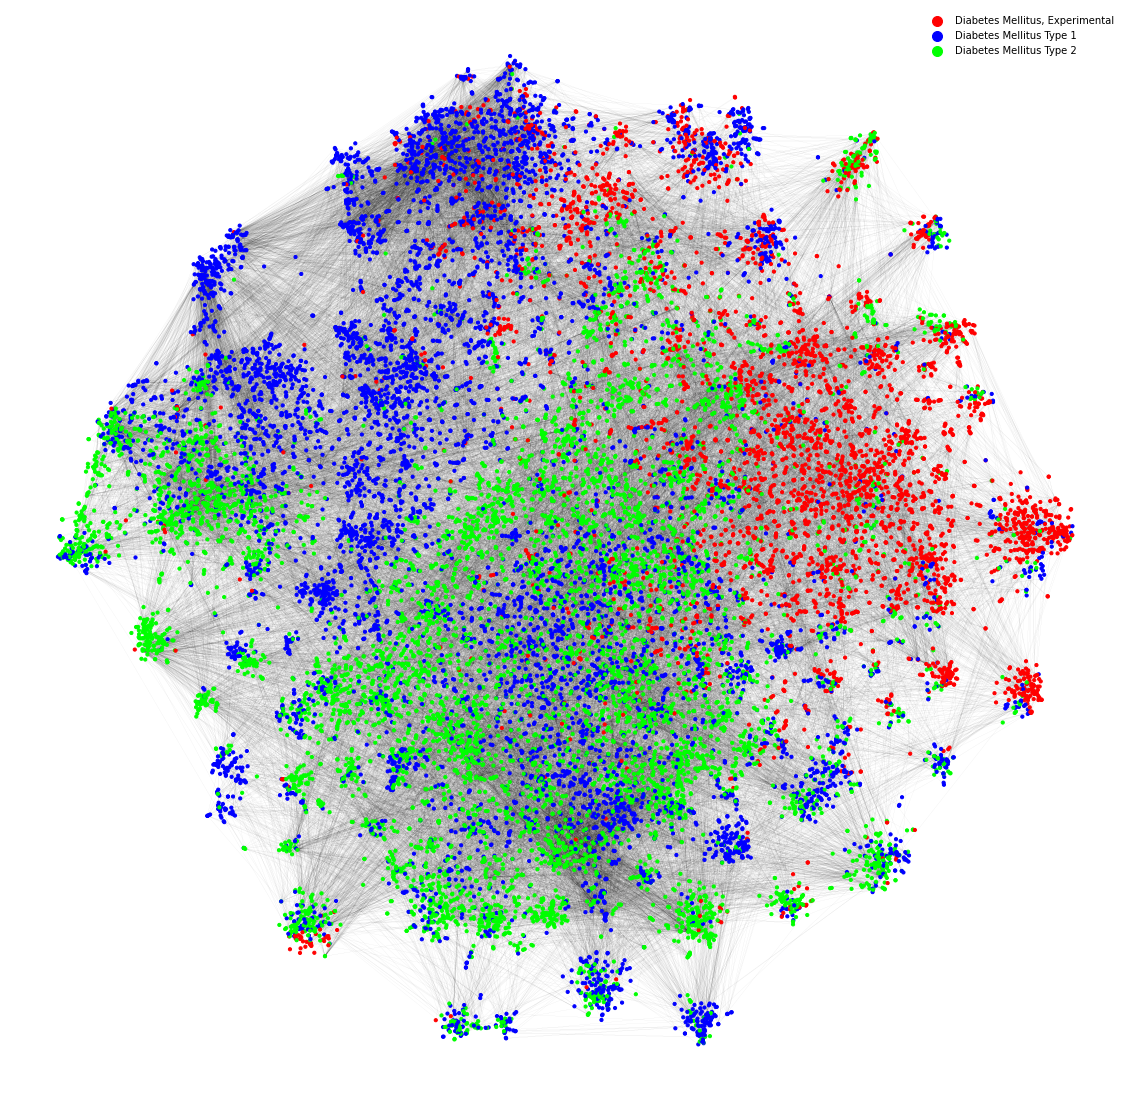

In [5]:
def show_graph(
        adj,
        pos,
        class_names,  # class_labels
        class_color,
        w=10,
        h=10,
        with_labels=False,
        alpha=1.0,
        padding=0.5,
        node_color='#8888FF',
        node_size=1000,
        node_shape='o',
        edge_color='#000000',
        edge_width=1.0,
        edge_style='solid',
        font_color='#000000',
        font_size=12):
    adj = sp.coo_matrix(adj)
    G = nx.from_scipy_sparse_matrix(adj)
    fig, ax = plt.subplots(figsize=(w, h))
    nx.draw(G,
            ax=ax,
            pos=pos,
            with_labels=with_labels,
            node_color=node_color,
            node_size=node_size,
            node_shape=node_shape,
            edge_color=edge_color,
            width=edge_width,
            style=edge_style,
            font_color=font_color,
            font_size=font_size)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(left=xmin - padding, right=xmax + padding)
    ax.set_ylim(bottom=ymin - padding, top=ymax + padding)
    if class_names is not None and class_color is not None:
        for name, color in zip(class_names, class_color):
            ax.scatter([], [], c=color, s=100, label=name)
        ax.legend(frameon=False)
    plt.close()
    return fig


adj = gd['adj']
true_labels = gd['true_labels']  # 每個節點的類別編號
class_labels = gd['class_labels']  # 類別標籤名稱

# 針對 citeseer 沒有標籤(true_labels[i] == -1)的節點加上 'Null'
if -1 in true_labels:
    class_names = class_labels + ['Null']
else:
    class_names = class_labels

# 各類別的色碼
class_color = get_num_str_colors(len(class_names), False)
# 轉換出 每一個節點對應顏色
color_labels = class_color[true_labels]  # node_color

print(f"class_names={class_names}")
print(f"class_color={class_color}")

# idx=0, label=1, color='#ff0000', name='Diabetes Mellitus, Experimental'
# idx=2, label=2, color='#0000ff', name='Diabetes Mellitus Type 1'
# idx=1, label=3, color='#00ff00', name='Diabetes Mellitus Type 2'

fig = show_graph(
    adj,
    pos,
    class_names=[
        'Diabetes Mellitus, Experimental', 'Diabetes Mellitus Type 1',
        'Diabetes Mellitus Type 2'
    ],  # class_names
    class_color=['#ff0000', '#0000ff', '#00ff00'],  # class_color
    w=20,
    h=20,
    node_size=10,
    edge_width=0.02,  #[0.1, 0.1, 0.02]
    with_labels=False,
    node_color=color_labels,
    padding=0.0)

fig.savefig(f"graph_{dataset_str}.png",
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.0)

fig